In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("..")

In [3]:
import os
from pathlib import Path
import pickle
import timeit
#
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms, models
from dotted_dict import DottedDict
from tqdm import tqdm
import pprint
#
from csprites.datasets import ClassificationDataset
import utils
from backbone import get_backbone
from optimizer import get_optimizer
from plot_utils import *

In [4]:
class Net(nn.Module):
    def __init__(self, n_classes, d_in, d_hid=1024, n_hid=0):
        super(Net, self).__init__()
        dims = [d_in]
        for _ in range(n_hid):
            dims.append(d_hid)
        dims.append(n_classes)
        #
        layers = []
        for idx in range(1, len(dims) - 1, 1):
            layers.append(nn.Linear(dims[idx - 1], dims[idx]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(dims[-2], dims[-1]))
        self.layers = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.layers(x)

def get_datasets(target_idx, p_R_train, p_R_valid, p_Y_train, p_Y_valid, batch_size):
    #
    R_train = torch.Tensor(np.load(p_R_train))
    R_valid = torch.Tensor(np.load(p_R_valid))
    #
    Y_train = torch.LongTensor(np.load(p_Y_train))
    Y_valid = torch.LongTensor(np.load(p_Y_valid))
    #
    d_r = R_train.shape[1]
    #
    Y_train = Y_train[:, target_idx]
    Y_valid = Y_valid[:, target_idx]
    #
    ds_train = torch.utils.data.TensorDataset(R_train, Y_train)
    ds_valid = torch.utils.data.TensorDataset(R_valid, Y_valid)

    dl_train = DataLoader(
        ds_train,
        batch_size=batch_size,
        pin_memory=True,
        shuffle=True)
    dl_valid = DataLoader(
        ds_valid,
        batch_size=batch_size,
        pin_memory=True,
        shuffle=True)
    return dl_train, dl_valid, d_r
    

def train_model(model, num_epochs, optimizer, criterion):
    stats = {
    'train': {
        'loss': [],
        'acc': [],
        'epoch': [],
    },
    'valid': {
        'loss': [],
        'acc': [],
        'epoch': [],
    }
    }
    stats = DottedDict(stats)
    desc_tmp = "Epoch [{:3}/{:3}] {}:"
    #
    for epoch_idx in range(1, num_epochs + 1, 1):
        ################
        # TRAIN
        ################
        model.train()
        epoch_step = 0
        epoch_loss = 0
        epoch_total = 0
        epoch_correct = 0
        #
        desc = desc_tmp.format(epoch_idx, num_epochs, 'train')
        pbar = tqdm(dl_train, bar_format= desc + '{bar:10}{r_bar}{bar:-10b}')
        #
        for x, y in pbar:
            x = x.to(device)
            y = y.to(device)
            for param in model.parameters():
                param.grad = None
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            #
            _, y_pred = torch.max(out, 1)
            total = y.size(0)
            correct = (y_pred == y).sum().item()
            #
            epoch_loss += loss.item()
            epoch_total += total
            epoch_correct += correct
            epoch_step += 1
            #
            pbar.set_postfix({'loss': loss.item(), 'acc': correct / total})
        stats.train.loss.append(epoch_loss / epoch_step)
        stats.train.acc.append(epoch_correct / epoch_total)
        stats.train.epoch.append(epoch_idx)

        ################
        # EVAL
        ################
        model.eval()
        epoch_step = 0
        epoch_loss = 0
        epoch_total = 0
        epoch_correct = 0
        #
        desc = desc_tmp.format(epoch_idx, num_epochs, 'valid')
        pbar = tqdm(dl_valid, bar_format= desc + '{bar:10}{r_bar}{bar:-10b}')
        #
        for x, y in pbar:
            x = x.to(device)
            y = y.to(device)
            with torch.no_grad():
                out = model(x)
                loss = criterion(out, y)
            #
            _, y_pred = torch.max(out, 1)
            total = y.size(0)
            correct = (y_pred == y).sum().item()
            #
            epoch_loss += loss.item()
            epoch_total += total
            epoch_correct += correct
            epoch_step += 1
            #
            pbar.set_postfix({'loss': loss.item(), 'acc': correct / total})
            #
        stats.valid.loss.append(epoch_loss / epoch_step)
        stats.valid.acc.append(epoch_correct / epoch_total)
        stats.valid.epoch.append(epoch_idx)
    return stats

# Settings

In [5]:
# linprob config
linprob_config = {
    'p_eval': 'eval',
    'p_eval_results': 'results.pkl',
    'p_config': "linprob_config.pkl",
    'p_results': 'results.pkl',
    'device': "cuda",
    'cuda_visible_devices': '0',
    'n_hid': 0,
    'd_hid': 1024,
    'batch_size': 1024,
    'optimizer': 'adam',
    'optimizer_args': {'lr': 0.001, 'weight_decay': 1e-6},
    'num_epochs': 20,
    'eval_name': "Width_and_Depth"
}
linprob_config = DottedDict(linprob_config)

In [6]:
# TORCH SETTINGS
torch.backends.cudnn.benchmark = True
os.environ["CUDA_VISIBLE_DEVICES"] = linprob_config.cuda_visible_devices
device = torch.device(linprob_config.device)

In [7]:
p_experiments_base = Path("/mnt/experiments/csprites/single_csprites_64x64_n7_c128_a32_p10_s3_bg_inf_random_function_100000")
p_experiments_base = p_experiments_base / "beta_architecture"
p_experiments = list(p_experiments_base.glob("Beta*"))
print("#Experiments: ", len(p_experiments))

#Experiments:  408


# RUN ALL

In [ ]:
step = 1
max_steps = len(p_experiments) * 2 * 6
print_str = "[{:>3}/{:>3}] {:>10} {:<10} {}"
for p_experiment in p_experiments:
    experiment_name = p_experiment.name
    
    # experiment config
    p_experiment_config = p_experiment / "config.pkl"
    with open(p_experiment_config, "rb") as file:
        experiment_config = pickle.load(file)
    # dataset config
    p_ds_config = Path(experiment_config.p_data) / "config.pkl"
    with open(p_ds_config, "rb") as file:
        ds_config = pickle.load(file)
    ds_reps = {
            "bacbone": {
                "R_train": experiment_config["p_R_train"],
                "R_valid": experiment_config["p_R_valid"],
                "Y_train": experiment_config["p_Y_train"],
                "Y_valid": experiment_config["p_Y_valid"],
                  },
           "betapro": {
               "R_train": experiment_config["p_R_train_bp"],
               "R_valid": experiment_config["p_R_valid_bp"],
               "Y_train": experiment_config["p_Y_train_bp"],
               "Y_valid": experiment_config["p_Y_valid_bp"],
                }
           }
    results = {ds_key: {} for ds_key in ds_reps.keys()}
    for ds_key in ds_reps.keys():
        for target_variable in ds_config["classes"]:
            print(print_str.format(step, max_steps, ds_key, target_variable, experiment_name))
            target_idx = [idx for idx, target in enumerate(ds_config["classes"]) if target == target_variable][0]
            n_classes = ds_config["n_classes"][target_variable]
            #
            dl_train, dl_valid, d_r = get_datasets(target_idx,
                                                   p_experiment / ds_reps[ds_key]["R_train"],
                                                   p_experiment / ds_reps[ds_key]["R_valid"],
                                                   p_experiment / ds_reps[ds_key]["Y_train"],
                                                   p_experiment / ds_reps[ds_key]["Y_valid"],
                                                   linprob_config.batch_size
                                                  )
            #
            model = Net(n_classes, d_r, linprob_config.d_hid, linprob_config.n_hid)
            model = model.to(device)
            #
            optimizer = get_optimizer(linprob_config.optimizer, model.parameters(), linprob_config.optimizer_args)
            criterion = nn.CrossEntropyLoss()
            #
            stats = train_model(model, linprob_config.num_epochs, optimizer, criterion)
            results[ds_key][target_variable] = stats
            step += 1
    p_results = p_experiment / linprob_config["p_results"]
    p_linprob_config = p_experiment / linprob_config["p_config"]
    #
    with open(p_results, "wb") as file:
        pickle.dump(results, file)
    with open(p_linprob_config, "wb") as file:
        pickle.dump(linprob_config, file)

# LOAD ALL RESULTS

In [9]:
p_experiments = list(p_experiments_base.glob("Beta*"))
print("#Experiments: ", len(p_experiments))

#Experiments:  408


In [116]:
experiment_results = {}
for p_experiment in p_experiments:
    experiment_name = p_experiment.name
    print(experiment_name)
    #
    p_results = p_experiment / linprob_config["p_results"]
    #
    with open(p_results, "rb") as file:
        results = pickle.load(file)
    experiment_results[experiment_name] = results

Beta[w0_dID]_Barlow[w2_d512][dkl10_a0.5_b0.5]_[ResNet-18]_2021-09-01_00-09-57
Beta[w2_d64]_Barlow[w1_d128][dkl10_a0.5_b0.5]_[ResNet-18]_2021-09-01_21-51-16
Beta[w0_dID]_Barlow[w3_d512][dkl10_a0.9_b0.1]_[ResNet-18]_2021-09-01_00-34-23
Beta[w0_dID]_Barlow[w3_d256][dkl10_a0.1_b0.9]_[ResNet-18]_2021-08-31_23-08-57
Beta[w2_d512]_Barlow[w0_dID][dkl10_a0.1_b0.1]_[ResNet-18]_2021-09-02_04-58-55
Beta[w2_d128]_Barlow[w2_d256][dkl10_a0.1_b0.9]_[ResNet-18]_2021-09-02_02-59-08
Beta[w1_d64]_Barlow[w2_d256][dkl10_a0.9_b0.1]_[ResNet-18]_2021-09-01_07-02-53
Beta[w1_d512]_Barlow[w3_d1024][dkl10_a0.1_b0.9]_[ResNet-18]_2021-09-01_15-52-34
Beta[w2_d64]_Barlow[w1_d64][dkl10_a0.1_b0.9]_[ResNet-18]_2021-09-01_21-14-19
Beta[w1_d1024]_Barlow[w2_d4096][dkl10_a0.1_b0.9]_[ResNet-18]_2021-09-01_19-09-43
Beta[w1_d512]_Barlow[w2_d2048][dkl10_a0.5_b0.5]_[ResNet-18]_2021-09-01_15-15-26
Beta[w1_d64]_Barlow[w3_d128][dkl10_a0.9_b0.1]_[ResNet-18]_2021-09-01_07-51-23
Beta[w1_d64]_Barlow[w3_d64][dkl10_a0.5_b0.5]_[ResNet-18]_

Beta[w1_d64]_Barlow[w2_d256][dkl10_a0.1_b0.1]_[ResNet-18]_2021-09-01_06-50-49
Beta[w1_d512]_Barlow[w2_d512][dkl10_a0.9_b0.1]_[ResNet-18]_2021-09-01_14-23-53
Beta[w0_dID]_Barlow[w1_d4096][dkl10_a0.5_b0.5]_[ResNet-18]_2021-09-01_03-24-53
Beta[w0_dID]_Barlow[w1_d256][dkl10_a0.9_b0.1]_[ResNet-18]_2021-08-31_20-55-22
Beta[w2_d1024]_Barlow[w1_d2048][dkl10_a0.1_b0.9]_[ResNet-18]_2021-09-02_09-58-17
Beta[w1_d1024]_Barlow[w2_d2048][dkl10_a0.1_b0.9]_[ResNet-18]_2021-09-01_18-44-50
Beta[w0_dID]_Barlow[w1_d1024][dkl10_a0.1_b0.9]_[ResNet-18]_2021-09-01_00-46-32
Beta[w0_dID]_Barlow[w3_d1024][dkl10_a0.1_b0.1]_[ResNet-18]_2021-09-01_02-23-45
Beta[w1_d512]_Barlow[w3_d512][dkl10_a0.5_b0.5]_[ResNet-18]_2021-09-01_15-40-17
Beta[w1_d1024]_Barlow[w2_d2048][dkl10_a0.5_b0.5]_[ResNet-18]_2021-09-01_18-57-17
Beta[w0_dID]_Barlow[w2_d4096][dkl10_a0.9_b0.1]_[ResNet-18]_2021-09-01_03-48-50
Beta[w1_d1024]_Barlow[w3_d4096][dkl10_a0.1_b0.1]_[ResNet-18]_2021-09-01_20-22-05
Beta[w2_d1024]_Barlow[w3_d2048][dkl10_a0.9_b0.

# FILTER RESULTS

In [346]:
accum_last_accs = 4
#
split = "valid"
acc_min = 0.65
#
experiment_name_inc = []
experiment_name_exc = ["Beta[w0_", "b0.5", "d512]_Barlow", "Barlow[w3"]

In [347]:
acc_results = []
#
experiment_names = []
for experiment_name in experiment_results.keys():
    cont = True
    for inc in experiment_name_inc:
        if inc not in experiment_name:
            cont = False
            break
    for exc in experiment_name_exc:
        if exc in experiment_name:
            cont = False
            break
    if not cont:
#         print("Exclude", experiment_name)
        continue
    results = experiment_results[experiment_name]
    feature_target_accs = []
    col_names = []
    app_result = True
    for target_name in feature_results.keys():
        for feature_name in results.keys():
            feature_results = results[feature_name]
            acc = np.mean(feature_results[target_name][split]["acc"][-accum_last_accs:])
            feature_target_accs.append(acc)
            if target_name == "shape" and acc < acc_min and feature_name == "betapro":
                app_result = False
            
            col_names.append("{}_{}".format(feature_name, target_name))
    if app_result:
        name = experiment_name[:-32]
        if name not in experiment_names:
            acc_results.append(feature_target_accs)
            experiment_names.append(experiment_name[:-32])
acc_results = np.array(acc_results)
feature_names = col_names

In [348]:
print(acc_results.shape)

(5, 12)


In [349]:
# sort
idcs_bb = acc_results[:,0].argsort()
idcs_bp = acc_results[:,1].argsort()
#
experiment_names_bb = np.array(experiment_names)[idcs_bb]
acc_matrix_bb = acc_results[idcs_bb]
#
experiment_names_bp = np.array(experiment_names)[idcs_bp]
acc_matrix_bp = acc_results[idcs_bp]

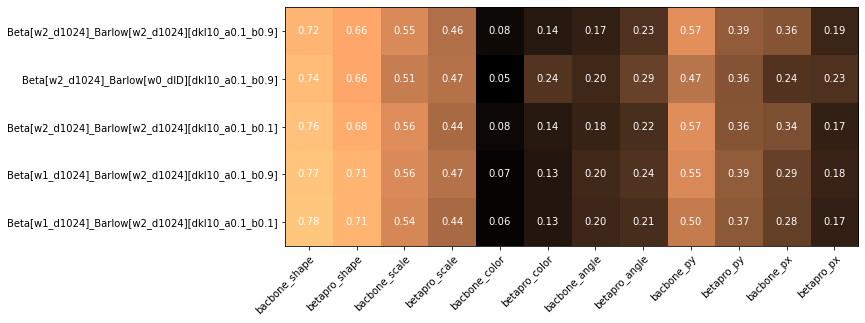

In [350]:
plot_mat(acc_matrix_bb, experiment_names_bb, feature_names, scale_factor=1)

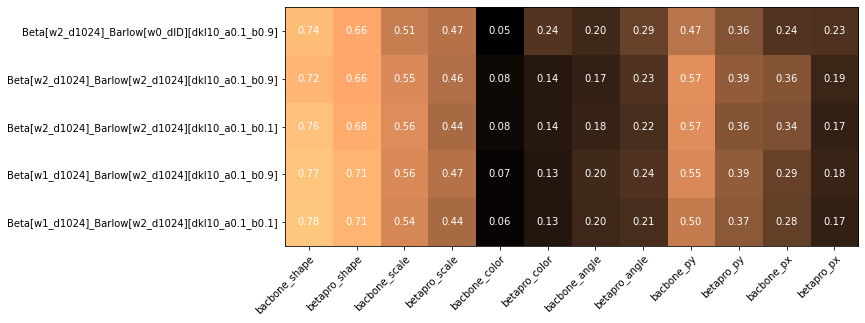

In [351]:
plot_mat(acc_matrix_bp, experiment_names_bp, feature_names, scale_factor=1)